<a href="https://colab.research.google.com/github/osu28/boilermakeIX/blob/main/satellite_convNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
REBUILD_DATA = True
class Compare():
  IMG_SIZE = 50
  new_york_city = "drive/MyDrive/cities/new_york_city"

  austin = "drive/MyDrive/cities/austin"
  LABELS = {new_york_city: 0, austin: 1}
  training_data = []
  new_york_city_count = 0
  austin_count = 0  
  
  def make_training_data(self):
    
    for label in self.LABELS:
      print("Labels: " + label)

      # images = glob.glob(label)
      # print("IMG: " + str(images))

      for f in tqdm(os.listdir(label)):
        
        try:
          path = os.path.join(label, f)
          img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
          img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
          
          self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

          if label == self.new_york_city:
            self.new_york_city_count += 1
          elif label == self.austin:
            self.austin_count += 1
        except Exception as e:
          print(str(e))
    np.random.shuffle(self.training_data)
    np.save("training_data.npy", self.training_data)
    print("")
    print("New York City: ", self.new_york_city_count)
    print("Austin: ", self.austin_count)

if REBUILD_DATA:
  compare = Compare()
  compare.make_training_data()

Labels: drive/MyDrive/cities/new_york_city


100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Labels: drive/MyDrive/cities/austin


100%|██████████| 20/20 [00:16<00:00,  1.25it/s]


New York City:  20
Austin:  20



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [4]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))
# print(training_data)

40


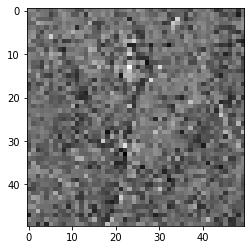

In [5]:
import matplotlib.pyplot as plt
plt.imshow(training_data[0][0], cmap="gray")
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F 

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 5) # 5x5 kernel to roll over features
    self.conv2 = nn.Conv2d(32, 64, 5)
    self.conv3 = nn.Conv2d(64, 128, 5)

    x = torch.randn(50, 50).view(-1, 1, 50, 50)
    self._to_linear = None
    self.convs(x)
    self.fc1 = nn.Linear(self._to_linear, 512)
    self.fc2 = nn.Linear(512, 2)

  def convs(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
    x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

    print(x[0].shape)
    if self._to_linear is None:
      self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
    return x
  
  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return F.softmax(x, dim=1)

net = Net()

torch.Size([128, 2, 2])


In [7]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1 # test against 10% of our training data
val_size = int(len(X) * VAL_PCT)
print(val_size)

4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


In [8]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[:-val_size]
test_y = y[:-val_size]


In [14]:
BATCH_SIZE = 2
EPOCHS = 10

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

 28%|██▊       | 5/18 [00:00<00:00, 49.26it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 18/18 [00:00<00:00, 47.16it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Epoch: 0. Loss: 0.25


  0%|          | 0/18 [00:00<?, ?it/s]

torch.Size([128, 2, 2])


 56%|█████▌    | 10/18 [00:00<00:00, 48.60it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 18/18 [00:00<00:00, 47.73it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Epoch: 1. Loss: 0.25


  0%|          | 0/18 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 10/18 [00:00<00:00, 48.37it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 18/18 [00:00<00:00, 47.15it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Epoch: 2. Loss: 0.25


  0%|          | 0/18 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 5/18 [00:00<00:00, 44.73it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])

 56%|█████▌    | 10/18 [00:00<00:00, 44.10it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 18/18 [00:00<00:00, 43.89it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


Epoch: 3. Loss: 0.25


  0%|          | 0/18 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 5/18 [00:00<00:00, 43.36it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 10/18 [00:00<00:00, 46.69it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


100%|██████████| 18/18 [00:00<00:00, 46.26it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Epoch: 4. Loss: 0.25


  0%|          | 0/18 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 5/18 [00:00<00:00, 44.55it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 10/18 [00:00<00:00, 44.61it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 15/18 [00:00<00:00, 42.98it/s]

torch.Size([128, 2, 2])


100%|██████████| 18/18 [00:00<00:00, 43.86it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Epoch: 5. Loss: 0.25


  0%|          | 0/18 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 5/18 [00:00<00:00, 42.50it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 10/18 [00:00<00:00, 44.17it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 15/18 [00:00<00:00, 44.22it/s]

torch.Size([128, 2, 2])


100%|██████████| 18/18 [00:00<00:00, 44.32it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Epoch: 6. Loss: 0.25


  0%|          | 0/18 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 5/18 [00:00<00:00, 44.97it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 10/18 [00:00<00:00, 45.42it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 15/18 [00:00<00:00, 42.13it/s]

torch.Size([128, 2, 2])


100%|██████████| 18/18 [00:00<00:00, 43.31it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Epoch: 7. Loss: 0.25


  0%|          | 0/18 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 5/18 [00:00<00:00, 41.13it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 10/18 [00:00<00:00, 43.33it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 15/18 [00:00<00:00, 43.32it/s]

torch.Size([128, 2, 2])


100%|██████████| 18/18 [00:00<00:00, 43.48it/s]


torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Epoch: 8. Loss: 0.25


  0%|          | 0/18 [00:00<?, ?it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 28%|██▊       | 5/18 [00:00<00:00, 45.84it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 56%|█████▌    | 10/18 [00:00<00:00, 45.43it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])


 83%|████████▎ | 15/18 [00:00<00:00, 44.98it/s]

torch.Size([128, 2, 2])


100%|██████████| 18/18 [00:00<00:00, 45.10it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Epoch: 9. Loss: 0.25


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 36/36 [00:00<00:00, 263.90it/s]

torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
torch.Size([128, 2, 2])
Accuracy:  0.5


In [12]:
torch.cuda.device_count()

0